In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
# conda install -c districtdatalabs yellowbrick
# pip install -U yellowbrick
from yellowbrick.cluster import KElbowVisualizer

pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)

In [2]:
def data_prep(dataframe):
    print(dataframe.head(), end="\n\n")
    print(dataframe.info(), end="\n\n")
    print(f"Shape: {dataframe.shape}", end="\n\n")
    # Missing values
    print(f"Count of null values: {dataframe.isnull().sum()}", end="\n\n")
    dataframe.dropna(inplace=True)
    # Number of unique items
    print(f"Number of unique items: {dataframe.nunique()}", end="\n\n")
    # How many of each product are there?
    dataframe["Description"].value_counts().head()
    # Sort 5 most ordered products from most to least.
    dataframe["Description"].value_counts().sort_values(ascending=False).head(5)
    # Remove canceled transactions
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    # Remove postage (no description)
    dataframe = dataframe[~(dataframe["Description"] == "POSTAGE")]
    # Create  TotalPrice: total earnings per invoice
    dataframe = dataframe[(dataframe['Quantity'] > 0)]
    dataframe = dataframe[(dataframe['Price'] > 0)]
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    return dataframe

In [3]:
def rfm_metrics_calculation(dataframe):
    #  Two days after the last date in the data
    today_date =  dataframe["InvoiceDate"].max() + pd.DateOffset(2)
    # Create rmf metrics
    dataframe = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                     'Invoice': lambda Invoice: Invoice.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})
    dataframe.columns = ['Recency', 'Frequency', 'Monetary']
    dataframe = dataframe[(dataframe["Monetary"] > 0)]
    
    return dataframe

In [4]:
def rfm_metrics_calculation_2(dataframe):
    #  Two days after the last date in the data
    today_date =  dataframe["InvoiceDate"].max() + pd.DateOffset(2)
    # Create rmf metrics
    dataframe = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                                                      'Invoice': lambda Invoice: Invoice.nunique(),
                                                      'TotalPrice': lambda TotalPrice: TotalPrice.sum(),
                                                      'Country': lambda Country: Country.unique()})
    dataframe.columns = ['Recency', 'Frequency', 'Monetary', 'Country']
    dataframe = dataframe[(dataframe["Monetary"] > 0)]
    
    return dataframe

In [5]:
def rfm_score_calculation(data):
    dataframe = data.copy()
    dataframe["Recency_Score"] = pd.qcut(dataframe['Recency'], 5, labels=[5, 4, 3, 2, 1])

    dataframe["Frequency_Score"] = pd.qcut(dataframe['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

    dataframe["Monetary_Score"] = pd.qcut(dataframe['Monetary'], 5, labels=[1, 2, 3, 4, 5])
    
    dataframe["RFM_Score"] = (dataframe['Recency_Score'].astype(str) + 
                              dataframe['Frequency_Score'].astype(str))
    seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'}
    
    dataframe['Segment'] = dataframe['RFM_Score'].replace(seg_map, regex=True)
    return dataframe

In [6]:
def create_clusters_kmeans(dataframe):
    scale = MinMaxScaler((0, 1))
    dataframe = scale.fit_transform(dataframe)
    
    kmeans = KMeans()
    elbow = KElbowVisualizer(kmeans, k=(2, 50))
    elbow.fit(dataframe)
    elbow.show()
    elbow.elbow_value_
    
    kmeans = KMeans(n_clusters=elbow.elbow_value_, random_state=17).fit(dataframe)
    cluster_no = kmeans.labels_
    return cluster_no

In [7]:
pip install openpyxl

     |████████████████████████████████| 242 kB 288 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [8]:
df_ = pd.read_excel("../input/online-retail-ll/online_retail_II.xlsx",sheet_name="Year 2010-2011")

In [9]:
df = df_.copy()

In [10]:
df = data_prep(df)

  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00    2.5      17850.0  United Kingdom
1  536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00    3.4      17850.0  United Kingdom
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00    2.8      17850.0  United Kingdom
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00    3.4      17850.0  United Kingdom
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00    3.4      17850.0  United Kingdom

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 

In [11]:
rfm = rfm_metrics_calculation(df)
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,327,1,77183.6
12347.0,3,7,4310.0
12348.0,76,4,1437.2
12349.0,20,1,1457.6
12350.0,311,1,294.4


In [12]:
rfm_score = rfm_score_calculation(rfm)
rfm_score.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,Segment
Customer ID,,,,,,,,
12346.0,327,1,77183.6,1,1,5,11,hibernating
12347.0,3,7,4310.0,5,5,5,55,champions
12348.0,76,4,1437.2,2,4,4,24,at_risk
12349.0,20,1,1457.6,4,1,4,41,promising
12350.0,311,1,294.4,1,1,2,11,hibernating


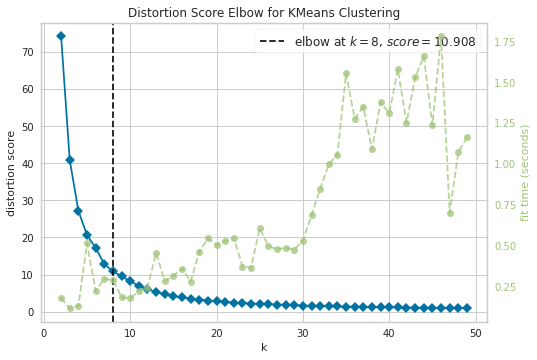

array([2, 5, 3, ..., 5, 5, 0], dtype=int32)

In [13]:
cluster_no = create_clusters_kmeans(rfm)
cluster_no

In [14]:
final_df = pd.DataFrame({"Clusters_Kmeans": cluster_no, "Segment": rfm_score.Segment})

In [15]:
# Cluster naming starts from 1 instead of 0
final_df["Clusters_Kmeans"] = final_df["Clusters_Kmeans"] + 1

In [16]:
final_df.index.rename("CustomerID", inplace=True)

In [17]:
final_df.reset_index(inplace=True)

In [18]:
final_df.head()

,CustomerID,Clusters_Kmeans,Segment
0,12346.0,3,hibernating
1,12347.0,6,champions
2,12348.0,4,at_risk
3,12349.0,6,promising
4,12350.0,3,hibernating


In [19]:
final_df.groupby(["Clusters_Kmeans", "Segment"]).count()

CustomerID
Clusters_Kmeans Segment                        
1               about_to_sleep              198
                loyal_customers             410
                need_attention               99
                potential_loyalists         183
                promising                    62
2               at_risk                     140
                cant_loose                   10
                hibernating                 205
3               at_risk                      28
                cant_loose                    3
                hibernating                 235
4               about_to_sleep              153
                at_risk                     165
                cant_loose                   29
                hibernating                 163
                loyal_customers             115
                need_attention               86
5               at_risk                     189
                cant_loose                   18
                hibernating                 183
6               champions                   624
                loyal_customers             289
                new_customers                44
                potential_loyalists         306
                promising                    37
7               at_risk                      60
                cant_loose                    2
                hibernating                 278
8               champions                    20
                loyal_customers               3
                potential_loyalists           1

In [20]:
# We see that the Kmeans clusters include multiple rfm segments.
# The Rfm Scoring method gives more accurate results than Kmeans. Because we set the rfm rules ourselves.

In [21]:
################### Add Country metric ###################

In [22]:
rfm_ =  rfm_metrics_calculation_2(df)

In [23]:
# Selection of customers shopping from different countries
rfm_[rfm_['Country'].apply(lambda x: isinstance(x, (np.ndarray)))]

,Recency,Frequency,Monetary,Country
Customer ID,,,,
12370.0,52,4,3425.7,"[Cyprus, Austria]"
12394.0,65,2,1080.5,"[Belgium, Denmark]"
12417.0,4,9,3226.1,"[Belgium, Spain]"
12422.0,97,3,683.6,"[Australia, Switzerland]"
12429.0,10,4,3388.4,"[Denmark, Austria]"
12431.0,37,15,6382.4,"[Australia, Belgium]"
12455.0,74,5,2339.9,"[Cyprus, Spain]"
12457.0,67,6,2043.2,"[Switzerland, Cyprus]"


In [24]:
index_list = rfm_[rfm_['Country'].apply(lambda x: isinstance(x, (np.ndarray, np.generic)))].index.tolist()
index_list

[12370.0, 12394.0, 12417.0, 12422.0, 12429.0, 12431.0, 12455.0, 12457.0]

In [25]:
# Drop customers shopping from different countries (select customers shopping from only one country)
rfm_ = rfm_[rfm_['Country'].apply(lambda x: isinstance(x, str))]

In [26]:
rfm_ohe = pd.get_dummies(rfm_, "Country", drop_first=True)

In [27]:
rfm_ohe.head()

,Recency,Frequency,Monetary,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,Country_Cyprus,Country_Czech Republic,Country_Denmark,Country_EIRE,Country_European Community,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Iceland,Country_Israel,Country_Italy,Country_Japan,Country_Lebanon,Country_Lithuania,Country_Malta,Country_Netherlands,Country_Norway,Country_Poland,Country_Portugal,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,327,1,77183.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
12347.0,3,7,4310.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348.0,76,4,1437.2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12349.0,20,1,1457.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12350.0,311,1,294.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


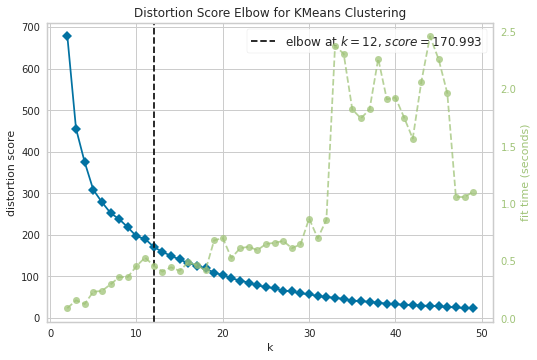

array([ 1,  4, 10, ...,  0,  0,  0], dtype=int32)

In [28]:
cluster_no = create_clusters_kmeans(rfm_ohe)
cluster_no

In [29]:
# The kmeans sse value increased a lot after adding the country metric.

In [30]:
# While creating the final_df, we should drop what we dropped from rfm_ also from rfm_score for the same indexes.
rfm_score2 = rfm_score.drop(index_list)

In [31]:
final_dff = pd.DataFrame({"Clusters_Kmeans": cluster_no, "Segment": rfm_score2.Segment, "Country": rfm_.Country})

In [32]:
final_dff["Clusters_Kmeans"] = final_dff["Clusters_Kmeans"] + 1

In [33]:
final_dff.index.rename("CustomerID", inplace=True)

In [34]:
final_dff.reset_index(inplace=True)

In [35]:
final_dff.head()

,CustomerID,Clusters_Kmeans,Segment,Country
0,12346.0,2,hibernating,United Kingdom
1,12347.0,5,champions,Iceland
2,12348.0,11,at_risk,Finland
3,12349.0,5,promising,Italy
4,12350.0,12,hibernating,Norway


In [36]:
final_dff.groupby(["Clusters_Kmeans", "Segment", "Country"]).count()

CustomerID
Clusters_Kmeans Segment             Country                         
1               about_to_sleep      United Kingdom               310
                at_risk             United Kingdom               114
                cant_loose          United Kingdom                22
                champions           United Kingdom               593
                hibernating         United Kingdom               112
                loyal_customers     United Kingdom               740
                need_attention      United Kingdom               175
                new_customers       United Kingdom                35
                potential_loyalists United Kingdom               449
                promising           United Kingdom                80
2               at_risk             United Kingdom                91
                cant_loose          United Kingdom                 5
                hibernating         United Kingdom               462
3               about_to_sleep      Germany                        6
                at_risk             Germany                        8
                champions           Germany                       11
                hibernating         Germany                       26
                loyal_customers     Germany                       23
                need_attention      Germany                        1
                new_customers       Germany                        2
                potential_loyalists Germany                       13
                promising           Germany                        4
4               about_to_sleep      France                         6
                at_risk             France                         3
                cant_loose          France                         1
                champions           France                        19
                hibernating         France                        25
                loyal_customers     France                        16
                need_attention      France                         3
                new_customers       France                         2
                potential_loyalists France                         9
                promising           France                         3
5               about_to_sleep      Cyprus                         1
                                    Czech Republic                 1
                                    Denmark                        2
                                    Israel                         1
                                    Italy                          2
                                    Japan                          1
                                    Netherlands                    1
                                    RSA                            1
                                    USA                            1
                at_risk             Austria                        1
                                    Canada                         1
                                    Channel Islands                3
                                    Denmark                        1
                                    EIRE                           1
                                    European Community             1
                                    Japan                          1
                                    Lithuania                      1
                                    Unspecified                    2
                champions           Channel Islands                1
                                    EIRE                           2
                                    Iceland                        1
                                    Italy                          1
                                    Netherlands                    1
                                    Sweden                         1
                hibernating         Australia           

In [37]:
# Let's look at set number 5. has too many countries and segments.
# Adding the country metric made the result worse. 